# importing libreries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# checking if cuda works
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# Image Preparation

 I coudn't upload the dataset to github because it is a large folder <br>
  you can find it here : <br>
link : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [3]:
#defining image path
train_path = 'chest_xray/train'
valid_path = 'chest_xray/val'
test_path  = 'chest_xray/test'

In [4]:
#preparing batches for the model

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224),classes=['NORMAL','PNEUMONIA'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224),classes=['NORMAL','PNEUMONIA'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224),classes=['NORMAL','PNEUMONIA'], batch_size=10, shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# splitting the batches into images and their corresponding labels
imgs, labels = next(train_batches)

In [6]:
# defining a function to plot our images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

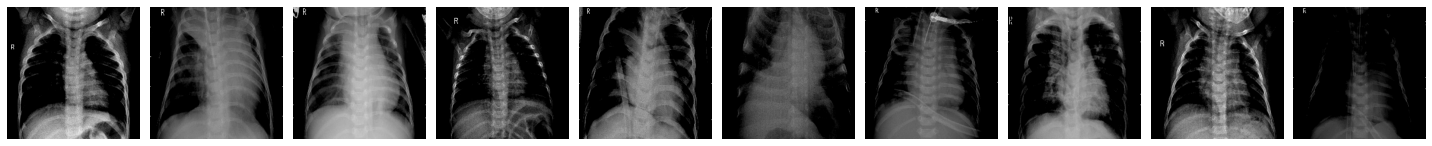

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [7]:
plotImages(imgs)
print(labels)

# building  and training the model

In [10]:
#  defining a function to  change the head of our MobileNetV2
def get_model():
    backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet', include_top=False,
    )
    backbone.trainable = False
    
    inputs = keras.layers.Input((224,224,3))
    
    x = backbone(inputs)
    x =  tf.keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    
    
    outputs = keras.layers.Dense(2,activation="softmax")(x)
    return keras.Model(inputs,outputs, name="mobilenetV2_on_imagenet")

In [11]:
model = get_model()
# Inspect the model summary
model.summary()

Model: "mobilenetV2_on_imagenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_4 (Dropout)         (None, 1024)  

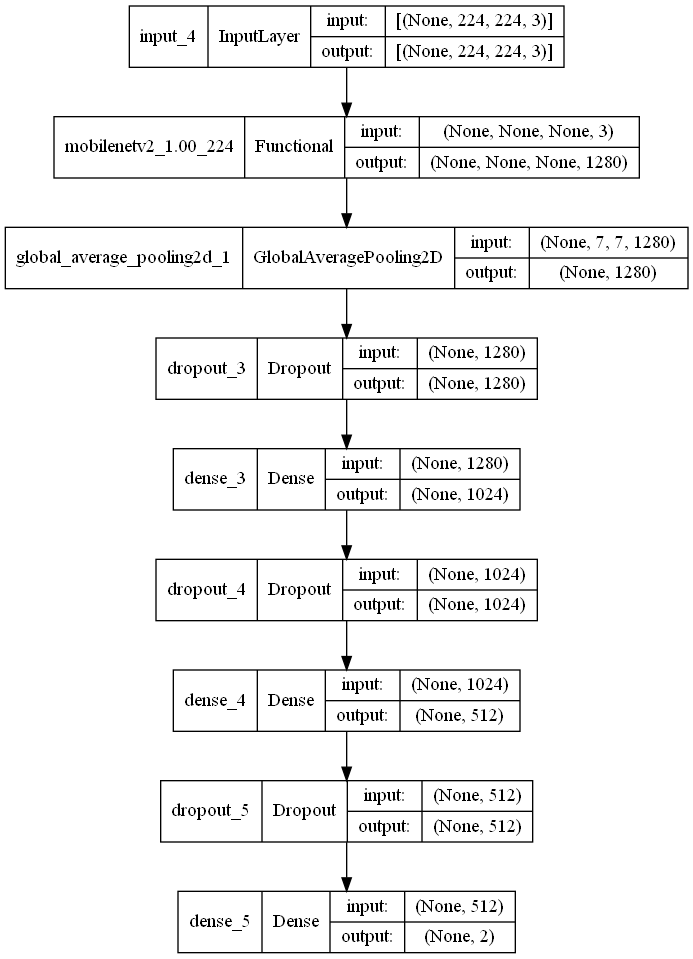

In [12]:
# Build a flow-diagram of the new MobileNet to see how information flows between the different layers
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file='ModelArchitecture.png', show_shapes=True, show_layer_names=True)
Image('ModelArchitecture.png')

In [13]:
# compiling MobileNetV2
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# fitting MobileNetV2
model.fit(
      x=train_batches
    , steps_per_epoch=len(train_batches)
    , validation_data=valid_batches
    , validation_steps=len(valid_batches)
    , epochs=10
    , verbose=2
)

Epoch 1/10
522/522 - 80s - loss: 0.1897 - accuracy: 0.9241 - val_loss: 0.2719 - val_accuracy: 0.9375 - 80s/epoch - 153ms/step
Epoch 2/10
522/522 - 62s - loss: 0.1184 - accuracy: 0.9578 - val_loss: 0.2969 - val_accuracy: 0.8750 - 62s/epoch - 119ms/step
Epoch 3/10
522/522 - 59s - loss: 0.0994 - accuracy: 0.9640 - val_loss: 0.1724 - val_accuracy: 0.9375 - 59s/epoch - 112ms/step
Epoch 4/10
522/522 - 66s - loss: 0.0844 - accuracy: 0.9674 - val_loss: 0.1487 - val_accuracy: 0.9375 - 66s/epoch - 127ms/step
Epoch 5/10
522/522 - 65s - loss: 0.0843 - accuracy: 0.9666 - val_loss: 0.4320 - val_accuracy: 0.8125 - 65s/epoch - 124ms/step
Epoch 6/10
522/522 - 60s - loss: 0.0778 - accuracy: 0.9707 - val_loss: 0.4039 - val_accuracy: 0.8750 - 60s/epoch - 114ms/step
Epoch 7/10
522/522 - 58s - loss: 0.0721 - accuracy: 0.9707 - val_loss: 0.1582 - val_accuracy: 0.8750 - 58s/epoch - 111ms/step
Epoch 8/10
522/522 - 62s - loss: 0.0677 - accuracy: 0.9745 - val_loss: 0.1087 - val_accuracy: 0.8750 - 62s/epoch - 119

# Testing the model

In [15]:
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

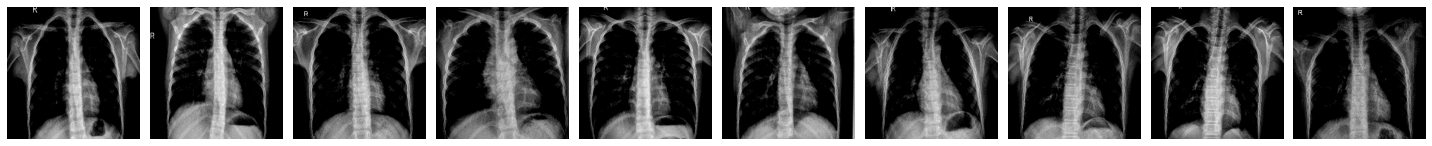

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [16]:
plotImages(test_imgs)
print(test_labels)

In [17]:
# predicting with the model
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [18]:
for i in np.round(predictions):
    print(i)

[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [19]:
# creating a confusion  matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [20]:
# taking a look into the classes of the test batches
test_batches.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [21]:
# defining the labels for the confusion matrix
cm_plot_labels = ['NORMAL','PNEUMONIA']

In [22]:
# defining a function to plot our confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[122 112]
 [  2 388]]


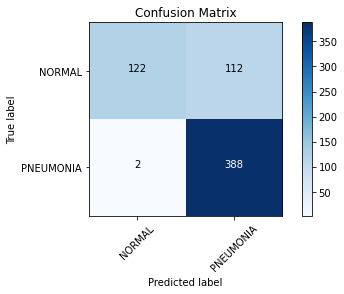

In [23]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# saving the model

In [24]:
from tensorflow.keras.models import load_model

In [27]:
# save the trained model
model.save('trained_model/model.h5')

In [28]:
# loading the trained model
new_model = load_model('trained_model/model.h5')